In [1]:
%load_ext autoreload
%autoreload 2

In [16]:
from typing import Any, Dict

import numpy as np
import scipy.sparse as sp
import torch
from jaxtyping import Float, Integer
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
from cycler import cycler

from src.graph_models.csbm import CSBM
from src.models.ntk import NTK
from src.attacks import create_attack

In [3]:
def configure_hardware(device, seed: int):
    torch.manual_seed(seed)
    np.random.seed(seed)

    # Hardware
    #torch.backends.cuda.matmul.allow_tf32 = other_params["allow_tf32"]
    #torch.backends.cudnn.allow_tf32 = other_params["allow_tf32"]
    if not torch.cuda.is_available():
        assert device == "cpu", "CUDA is not availble, set device to 'cpu'"
    elif device == "cpu":
        device = torch.device("cpu")
    else:
        device = torch.device(f"cuda:{device}")

    return device

In [27]:
# Data
classes = 2
n = 1000
#n_per_class_trn = 400
K_l = [0.1, 0.5, 1, 1.5, 2, 5]
sigma = 1
avg_within_class_degree = 1.58 * 2
avg_between_class_degree = 0.37 * 2
seed = 42
# Model
model_dict = {
    "label": "GCN",
    "model": "GCN",
    "normalization": "row_normalization",
    "depth": 1,
}
attack_params = {
    "attack": "noise"
}
# Attack
eps_l = [0, 0.01, 0.025, 0.05, 0.10, 0.25, 0.50, 1, 2.5, 5, 10]
# other
device = "cpu"
dtype = torch.float64


In [5]:
def get_graph(sort: bool=True):
    """Return graph sampled from a CSBM.

    If sort is true, X, A and y are sorted for class.
    
    Returns X, A, y."""
    csbm = CSBM(n, avg_within_class_degree, avg_between_class_degree, K, sigma, classes=classes)
    X, A, y = csbm.sample(n, seed)
    device_ = configure_hardware(device, seed)
    X = torch.tensor(X, dtype=dtype, device=device_)
    A = torch.tensor(A, dtype=dtype, device=device_)
    y = torch.tensor(y, device=device_)
    if sort:
        _, idx = y.sort()
        y = y[idx]
        X = X[idx, :]
        A = A[idx, :]
        A = A[:, idx]
    return X, A, y


def row_normalize(A):
    # Row normalize
    S = torch.triu(A, diagonal=1) + torch.triu(A, diagonal=1).T
    S.data[torch.arange(S.shape[0]), torch.arange(S.shape[0])] = 1
    Deg_inv = torch.diag(torch.pow(S.sum(axis=1), - 1))
    return Deg_inv @ S


def get_diffusion(X, A, model_dict):
    if model_dict["model"] == "GCN":
        if model_dict["normalization"] == "row_normalization":
            return row_normalize(A)
        else:
            raise NotImplementedError("Only row normalization for GCN implemented")
    else:
        raise NotImplementedError("Only GCN architecture implemented")
    
def count_edges_for_idx(A: Float[torch.Tensor, "n n"], idx: np.ndarray):
    '''count edges connected to nodes in idx'''
    row, col = A.triu().to_sparse().indices()

    mapping = torch.zeros(A.size(dim=0)).bool()
    mapping[idx]=True # True if node in idx

    mask_col = mapping[col] # True if col in idx
    mask_row = mapping[row] # True if row in idx
    mask_row_col = torch.logical_or(mask_col, mask_row) # True if either row or col in idx -> edges connected to idx
    return mask_row_col.sum().cpu().item()



0.0060866353496358255

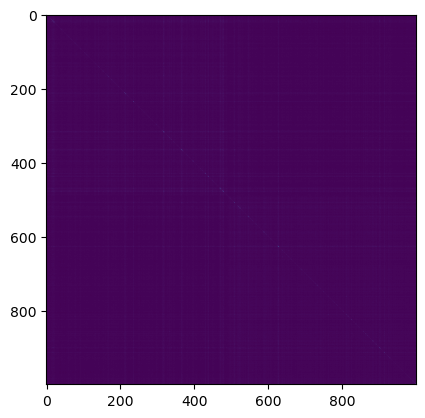

In [240]:
X, A, y = get_graph()
S = get_diffusion(X, A, model_dict)
# Computing NTK
ntk = NTK(X, S, model_dict)
fig, ax = plt.subplots()
ntk_np = ntk.get_ntk().detach().cpu().numpy()
im = ax.imshow(ntk_np)
im.norm(1)

In [15]:
ntk_dict = dict()
for K in K_l:
    # Sample
    X, A, y = get_graph()
    target_idx = np.arange(A.shape[0])
    S = get_diffusion(X, A, model_dict)
    # Init Attack
    attack = create_attack(target_idx, X, A, y, {"attack":"noise"}, seed)
    # Computing NTK
    ntk_l = list()
    for eps in eps_l:
        n_pert = int(round(eps * count_edges_for_idx(A, target_idx)))
        print(n_pert)
        A_pert = attack.attack(n_pert)
        S = get_diffusion(X, A_pert, model_dict)
        ntk_l.append(NTK(X, S, model_dict))
    ntk_dict[K] = ntk_l

0
19
49
97
195
487
974
1947
4868
9735
19470
0
19
49
97
195
487
974
1947
4868
9735
19470
0
19
49
97
195
487
974
1947
4868
9735
19470
0
19
49
97
195
487
974
1947
4868
9735
19470
0
19
49
97
195
487
974
1947
4868
9735
19470
0
19
49
97
195
487
974
1947
4868
9735
19470


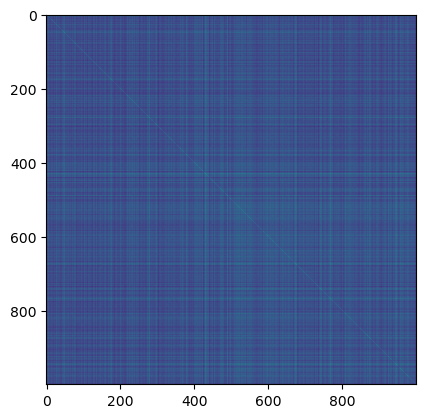

In [250]:
ntk_l = ntk_dict[1.5]
ntk = ntk_l[10].get_ntk().detach().cpu().numpy()
fig, ax = plt.subplots()
im = ax.imshow(ntk)


In [7]:
def calc_kernel_means(ntk: NTK, n_class0: int):
    ntk = ntk.get_ntk()
    mask_class0 = torch.zeros((n,n), dtype=torch.bool)
    mask_class0[:n_class0, :n_class0] = True
    mask_class0 = mask_class0.triu(diagonal=1)
    mask_interclass = torch.zeros((n,n), dtype=torch.bool)
    mask_interclass[:n_class0, n_class0:] = True
    mask_class1 = torch.zeros((n,n), dtype=torch.bool)
    mask_class1[n_class0:, n_class0:] = True
    mask_class1 = mask_class1.triu(diagonal=1)
    avg_class0 = ntk[mask_class0].mean().detach().cpu().item()
    std_class0 = ntk[mask_class0].std().detach().cpu().item()
    avg_class1 = ntk[mask_class1].mean().detach().cpu().item()
    std_class1 = ntk[mask_class1].std().detach().cpu().item()
    avg_interclass = ntk[mask_interclass].mean().detach().cpu().item()
    std_interclass = ntk[mask_interclass].std().detach().cpu().item()
    mask_inclass = mask_class0.logical_or(mask_class1)
    avg_inclass = ntk[mask_inclass].mean().detach().cpu().item()
    std_inclass = ntk[mask_inclass].std().detach().cpu().item()
    m = mask_interclass.sum()
    k = mask_inclass.sum()
    std_diff = torch.sqrt(1 / m * std_interclass**2 + 1/k * std_inclass**2) # upper bound to true std due to ignoriance of (negative) correlation term
    std_diff = std_diff.detach().cpu().item()
    return avg_class0, std_class0, avg_class1, std_class1, \
        avg_interclass, std_interclass, avg_inclass, std_inclass, std_diff



In [270]:
calc_kernel_means(ntk_l[4], n_class0)

(1.5938003942603507,
 0.6115609060501668,
 1.6102559731551527,
 0.5424364046971197,
 1.4250811624752122,
 0.5191984703807301,
 1.6023574930690478,
 0.5767078049134339,
 0.0015528036747127771)

In [9]:
print(ntk_l)

[NTK(), NTK(), NTK(), NTK(), NTK(), NTK(), NTK(), NTK(), NTK(), NTK(), NTK()]


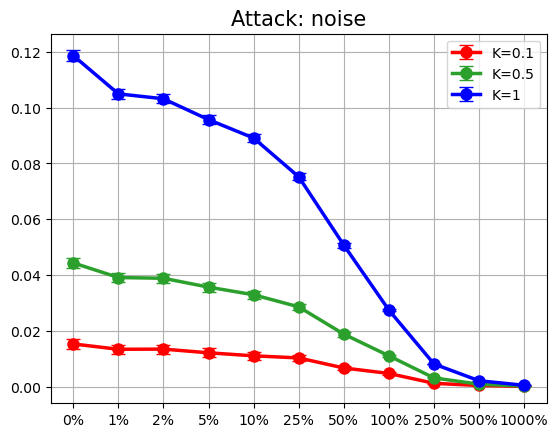

In [31]:
n_class0 = (y==0).sum()
n_class1 = (y==1).sum
color_list = ['r', 
             'tab:green', 
             'b', 
             'lime', 
             'slategrey', 
             'k', 
             "lightsteelblue",
             "antiquewhite",
             ]
linestyle_list = ['-', '--', ':', '-.']
fig, ax = plt.subplots()
ax.set_prop_cycle(cycler('color', color_list))
x = np.arange(len(eps_l))
for K in K_l[:-3]:
    ntk_l = ntk_dict[K]
    y_val = []
    y_std = []
    for ntk in ntk_l:
        _, _, _, _, avg_interclass, std_interclass, avg_inclass, std_inclass, \
            diff_std = calc_kernel_means(ntk, n_class0)
        y_val.append(avg_inclass - avg_interclass)
        y_std.append(diff_std)
    ax.errorbar(x, y_val, yerr=y_std, marker="o", linestyle="-",
                label=f"K={K}", capsize=5, linewidth=2.5, markersize=8)
ax.xaxis.set_ticks(x, minor=False)
xticks = [f"{eps*100:.0f}%" for eps in eps_l]
ax.xaxis.set_ticklabels(xticks, fontsize=10, fontweight="normal")
ax.yaxis.grid()
ax.xaxis.grid()
ax.set_title("Attack: " + attack_params["attack"], fontweight="normal", fontsize=15)        
ax.legend()